# Tuango - Targeting Mobile App Messages


In [1]:
import numpy as np
import pandas as pd
import polars as pl
import pyrsm as rsm
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')



In [2]:
# check that you have version 0.9.10 of pyrsm or newer
rsm.__version__

'0.9.13'

In [3]:
rsm.__file__

'/home/jovyan/.rsm-msba/lib/python3.11/site-packages/pyrsm/__init__.py'

In [4]:
# Use this dataset and notebook to answer questions 1-13
tuango = pd.read_parquet("data/tuango_post.parquet")

In [5]:
tuango.head()

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1
3,U40811142,no,0.0,277,1.0,40.000000,37,F,yes,0.0,1
4,U76283952,no,0.0,259,1.0,21.000000,43,F,yes,1.0,1


In [7]:
# dataset description
tuango_description = rsm.md("data/tuango_post_description.md")

# Tuango: Targeting Mobile App Push Messages

This file has the roll-out results. There are no missing values for `buyer` and `ordersize`. The other variables are the same as in the pre dataset.

## Variable Names and Descriptions
* userid: Unique user ID

**Response to the customized push message**
* buyer: Did the customer buy the Karaoke deal? ("yes" or "no")
* ordersize: Number of 30-minute Karaoke sessions the customer purchased

**Recency, Frequency, and Monetary variables**
* recency: Days since last purchase of a deal (before the Karaoke deal offer)
* frequency: Number of deals purchased during the one year period before the Karaoke deal offer
* monetary: Average amount spent per order (in RMB) during the one year period before the Karaoke deal offer

**Other variables in the dataset**
* age: Age of the customer
* gender: Gender identity of the customer (M = male, F = female, O = Other or unknown)
* music: Customer made a purchase in the music category during the one-year period before the Karaoke deal offer ("no" or "yes")
* test: Splits the dataset into test (1) and rollout (0) data
* training: Splits the dataset into training (1) and test (0) data. This variable will not be used in this assignment

In [8]:

# There are missing values in the data that we will need to deal with)
tuango.buyer.value_counts(dropna=False)

buyer
no     377925
yes     40235
Name: count, dtype: int64

In [9]:
tuango.buyer.isna().value_counts()

buyer
False    418160
Name: count, dtype: int64

In [10]:
# create a variable called 'buyer_yes' that has value 1 when buyer == 'yes', has value 0 when buyer == 'no' and has value np.nan when buyer.isna() is True
tuango["buyer_yes"] = 1
tuango.loc[tuango["buyer"] == 'no', 'buyer_yes'] = 0
tuango.loc[tuango.buyer.isna() == True, 'buyer_yes'] = np.nan

# you can check that you have this set up correctly using the command below
tuango.buyer_yes.value_counts(dropna=False)

buyer_yes
0.0    377925
1.0     40235
Name: count, dtype: int64

In [11]:
tuango.head(3)

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1,0.0
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1,0.0
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1,0.0


## Part I:  Preliminary Analysis


Find the percentage of customers responded to the deal offer message (i.e., bought the deal)

In [12]:
# insert calculation code here
# the result should be expressed as a percentage as a string with 2 decimal 
# places and assigned to q1 (e.g., q1 = '5.43%')
q1_dat = tuango.groupby('buyer_yes').agg(counts=('buyer_yes', 'count')).reset_index()
q1_dat['perc'] = (q1_dat['counts'] * 100 / q1_dat['counts'].sum()).round(2).astype(str) + '%'
q1 = q1_dat[q1_dat['buyer_yes'] == 1.0]['perc'].iloc[0]
q1

'9.62%'

Find the average number of sessions purchased by customers that bought one or more 30-minute sessions. Use the ordersize variable for the calculation.

Create a pivot table with count, mean and std. deviation of `ordersize` by `buyer`

In [13]:
tuango.head(3)

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1,0.0
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1,0.0
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1,0.0


In [14]:
q2 = tuango.pivot_table(index='buyer', columns= ['test'], values = ['ordersize'], aggfunc = ['count', 'mean', 'std'])
print(q2)
print(q2.loc["yes", "mean"])

          count             mean                 std          
      ordersize        ordersize           ordersize          
test          0      1         0         1         0         1
buyer                                                         
yes       38215   2020  3.937956  3.941089  1.697007  1.701904
no       359037  18888  0.000000  0.000000  0.000000  0.000000
           test
ordersize  0       3.937956
           1       3.941089
Name: yes, dtype: float64


In [15]:
len(tuango[tuango['test']==1])

20908

No plot will be created for userid (type object)


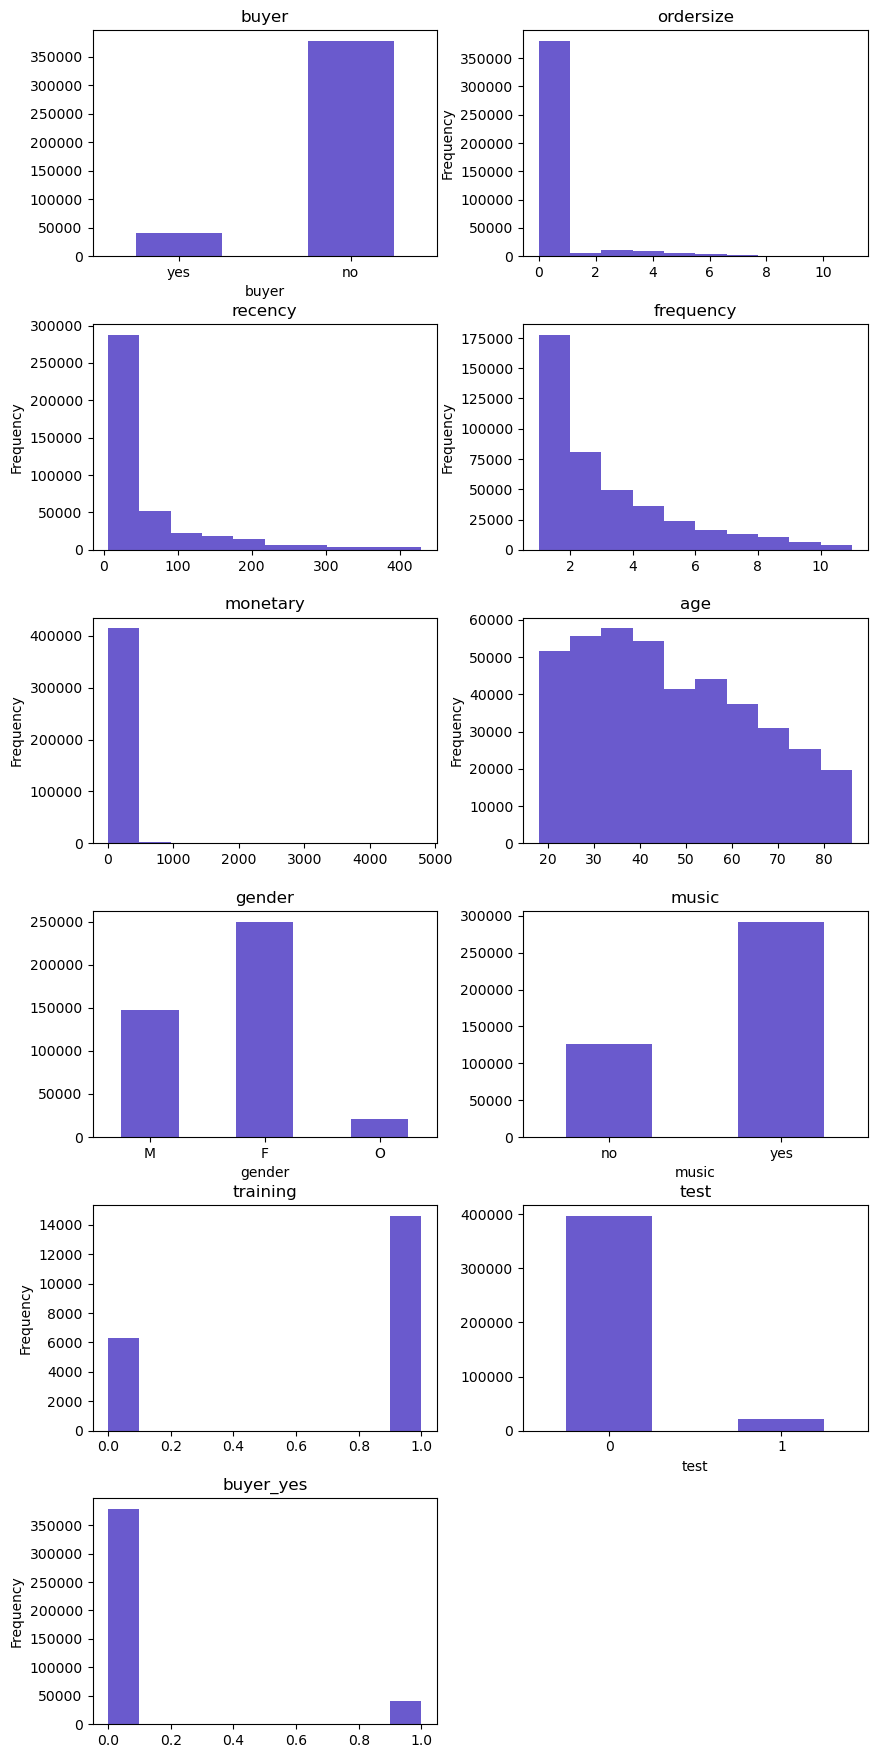

In [16]:
rsm.distr_plot(tuango)

## Part II: Building Targeting Models

Estimate a logistic regression model using buyer as the dependent variable (target) and, recency, frequency, monetary, age, gender, and music as the explanatory variables (features)

In [17]:
# Filter only data in a test
tuango_fil = tuango
tuango_fil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418160 entries, 0 to 418159
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   userid     418160 non-null  object  
 1   buyer      418160 non-null  category
 2   ordersize  418160 non-null  float64 
 3   recency    418160 non-null  int32   
 4   frequency  418160 non-null  float64 
 5   monetary   418160 non-null  float64 
 6   age        418160 non-null  int32   
 7   gender     418160 non-null  category
 8   music      418160 non-null  category
 9   training   20908 non-null   float64 
 10  test       418160 non-null  int32   
 11  buyer_yes  418160 non-null  float64 
dtypes: category(3), float64(5), int32(3), object(1)
memory usage: 25.1+ MB


In [18]:
lr = rsm.model.logistic(data={'tuango':tuango_fil}, rvar='buyer', lev='yes', evar=['recency', 'frequency', 'monetary', 'age', 'gender', 'music'])
lr.summary()

Logistic regression (GLM)
Data                 : tuango
Response variable    : buyer
Level                : yes
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

               OR     OR%  coefficient  std.error  z.value p.value     
Intercept   0.050  -95.0%        -2.99      0.022 -138.153  < .001  ***
gender[F]   1.759   75.9%         0.56      0.012   46.145  < .001  ***
gender[O]   1.071    7.1%         0.07      0.029    2.373   0.018    *
music[yes]  1.879   87.9%         0.63      0.013   47.753  < .001  ***
recency     0.999   -0.1%        -0.00      0.000  -14.782  < .001  ***
frequency   1.121   12.1%         0.11      0.002   51.307  < .001  ***
monetary    1.002    0.2%         0.00      0.000   57.229  < .001  ***
age         0.987   -1.3%        -0.01      0.000  -41.380  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squar

Create Prediction plots for all explanatory variables. Describe the effect of each explanatory variable on the probability that a customer will purchase the karaoke deal

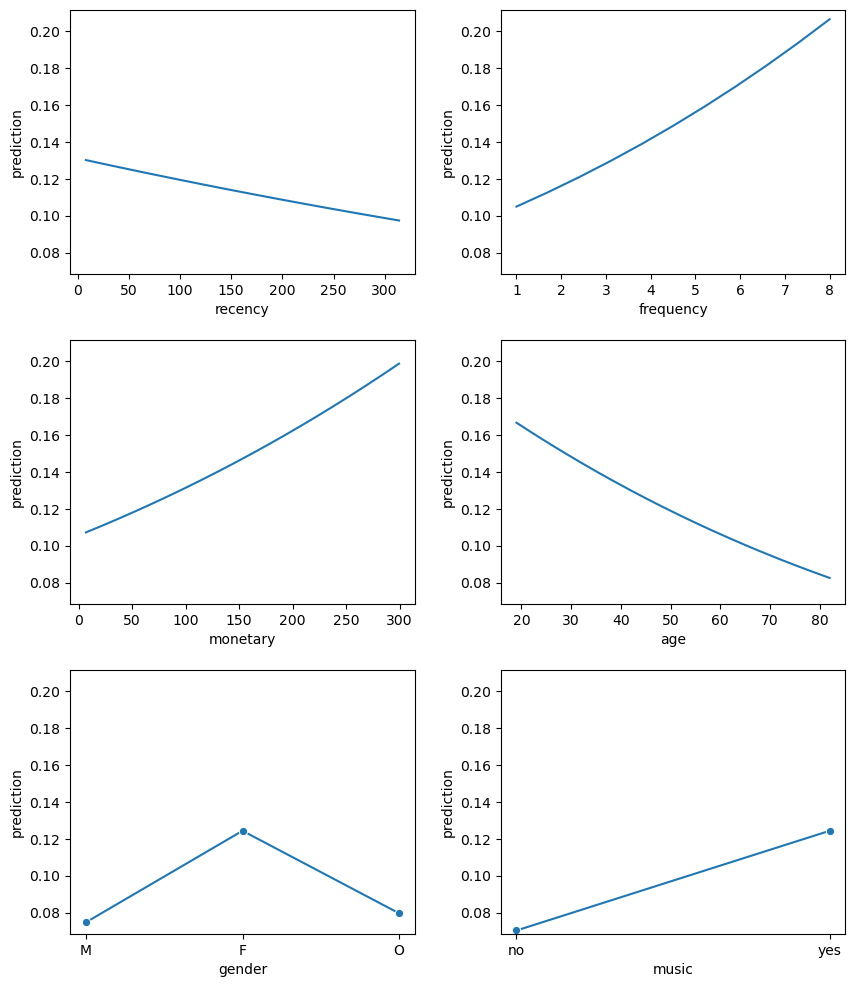

In [19]:
lr.plot('pred')

*There are *6 features* that we have to take into consideration.*
1) Recency
    > From its graph, it can be seen that if recency, the date from the last purchase, increases, the 
    > probability of buying a deal would decrease steadily keeping all other variables constant.
2) Frequency
    > It can observe that frequency of buying deal within one year seems to be an essential entity for recipients having a high likelihood to buy karaoke deals
3) Monetary
    > Similarly, a positive correlation between money spending per order and possibility of purchasing deals also exists.
4) Music
    > This variable follows the trends of both *monetary* and *frequency*
5) Gender
    > It seems like this variable is not that much correlate with our dependent variable; however, female > seems to have positive affect to 'buyer' variable.
6) Age
    > Age has positive correlation with the possibility of accepting deals. Meaning, the older 
    > observations have, the less likely they might purchase karaoke deals.
    

Using Permutation Importance to assess variable importance. Therefore, finding variables that seem to be most important in the model

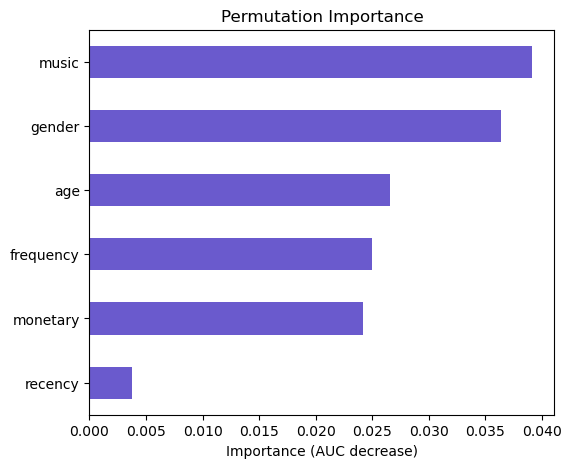

In [20]:
lr.plot("vimp")

The most important variable among all is *music*. For the analytical point of view, it does make sense because people who used to purchase deals regarding music category should have a strong correlation with karaoke deals in some ways or others.

Add the predicted values from the logistic regression to the "tuango" DataFrame. Use "pred_logit" as the variable name. Compare the average of the predicted values to the overall response rate (i.e., percentage of buyers).

In [21]:
tuango['pred_logit'] = lr.predict(data=tuango)['prediction']

In [22]:
tuango.head(3)

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes,pred_logit
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1,0.0,0.143066
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1,0.0,0.063879
2,U22965759,no,0.0,295,1.0,72.900002,59,F,yes,1.0,1,0.0,0.071288


In [23]:
tuango_fil = tuango
tuango_fil_cal = tuango_fil.groupby('buyer').agg(avg_pred_value=('pred_logit', 'mean'))
tuango_fil_cal['avg_pred_value'] = (tuango_fil_cal['avg_pred_value']*100).round(2).astype('str') + '%'
tuango_fil_cal['overall_response_rate'] = (tuango.buyer.value_counts(normalize=True)*100).round(2).astype('str')+'%'
tuango_fil_cal

,avg_pred_value,overall_response_rate
buyer,,
yes,12.91%,9.62%
no,9.27%,90.38%


From buyer (Yes), the average prediction value is higher than overall response rate indicating the model estimate 12.75% probability that they will accept a deal in buyer (yes) group. Moreover, there is a lower average prediction value for non-buyer as the model illustrate that customers in this group have only 9.33% chance of getting an offer. However, baseline should be set up, potentially breakeven point so that we can measure the efficiency of this model.

Estimate a linear regression model using "ordersize" as the response variable and recency, frequency, monetary, age, gender, and music as the explanatory variables. Estimate this regression using only those customers who placed an order after the deal offer message.

In [24]:
# Filter only customers who place order
tuango_fil_reg = tuango_fil[tuango_fil['ordersize']>0]

In [25]:
reg = rsm.regress({"tuango_fil_reg": tuango_fil_reg}, rvar="ordersize", evar=["recency", 'frequency', 'monetary', 'age', 'gender', 'music']) # rvar = y, evar = x
reg.summary()

Linear regression (OLS)
Data                 : tuango_fil_reg
Response variable    : ordersize
Explanatory variables: recency, frequency, monetary, age, gender, music
Null hyp.: the effect of x on ordersize is zero
Alt. hyp.: the effect of x on ordersize is not zero

            coefficient  std.error  t.value p.value     
Intercept         3.715      0.039   96.382  < .001  ***
gender[F]         0.099      0.020    5.019  < .001  ***
gender[O]         0.242      0.047    5.163  < .001  ***
music[yes]        0.007      0.022    0.328   0.743     
recency           0.000      0.000    3.805  < .001  ***
frequency         0.024      0.003    6.875  < .001  ***
monetary          0.000      0.000    5.993  < .001  ***
age               0.000      0.001    0.528   0.598     

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-squared: 0.003, Adjusted R-squared: 0.003
F-statistic: 19.992 df(7, 40227), p.value < 0.001
Nr obs: 40,235


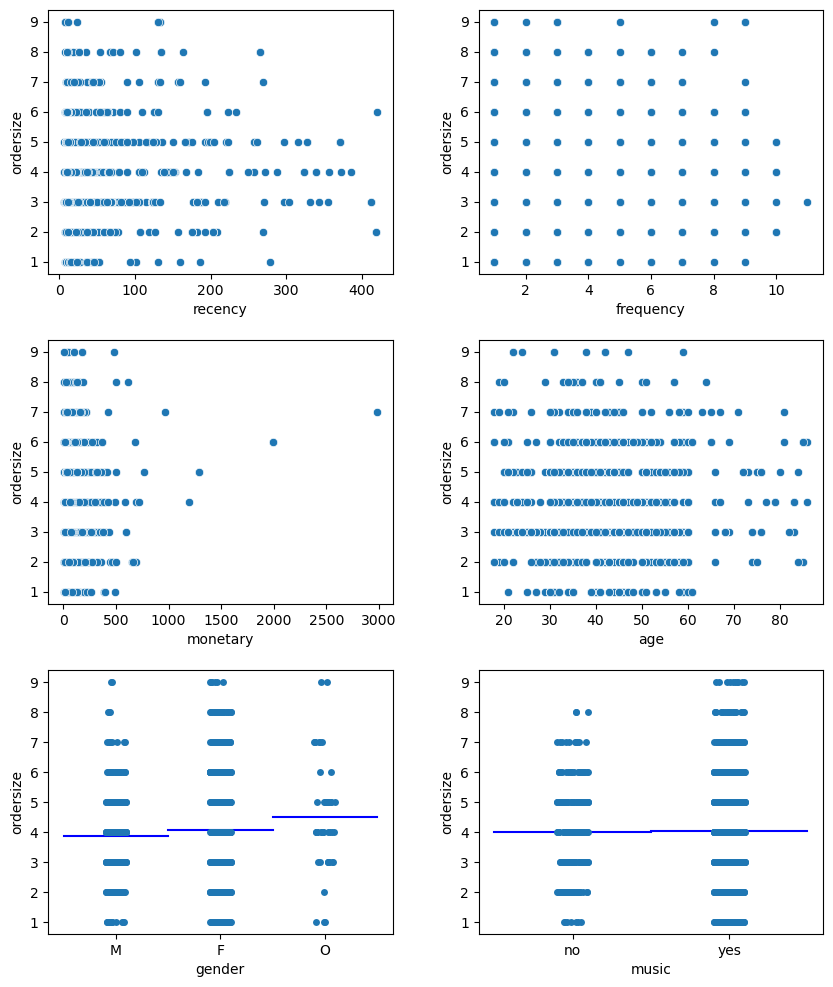

In [26]:
reg.plot('scatter')

There a problem here, if we use linear regression to analyze having *ordersize* as a response variable. One main thing is that although the p-value is less than 0.05; hence, we can reject the null hypothesis that every feature has no significant effect to a response variable; however, R-square is significantly low. As such, this model needs to be implemented.


Use Permutation Importance to assess variable importance.

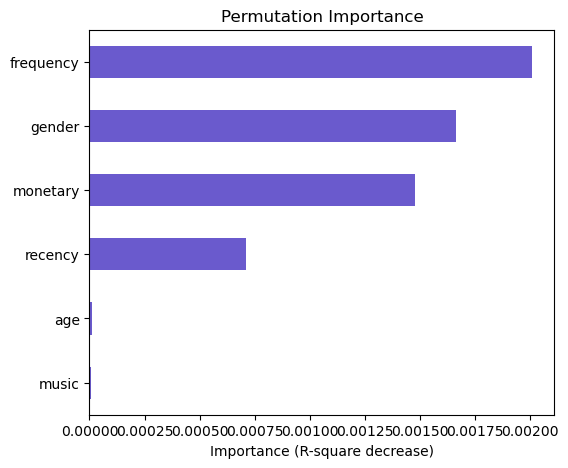

In [27]:
reg.plot("vimp")

Diametrically, *music* is the most insignificant variable here. Frequency; however, seem to be the most important for this regression model.

This model is useless. To elaborate, if we try to predict the ordersize for customers who accepted deals, we are likely to have unfavorable outcome. As you can see, the p-value of this model can't reject the null hypothesis. Moreover, by roughly plotting scatter plots regarding explanatory variables, none of them exhibits a linear relationship with ordersize.

Add the predicted values from the linear regression to the "tuango" data.frame. Compare the average of the predicted values to the average value of ordersize.

In [28]:
tuango_fil_reg['predict_reg'] = reg.predict(data=tuango_fil_reg)['prediction']
ordersize_means = tuango_fil_reg[['ordersize', 'predict_reg']][(tuango_fil_reg['test']==1)].mean()
ordersize_means

ordersize      3.941089
predict_reg    3.936686
dtype: float64

The means of *predicted variables* is lower than that of ordersize.

In [29]:
# Cross-check mean values
tuango_fil_reg.describe()

,ordersize,recency,frequency,monetary,age,training,test,buyer_yes,pred_logit,predict_reg
count,40235.000000,40235.000000,40235.000000,40235.000000,40235.000000,2020.000000,40235.000000,40235.0,40235.000000,40235.000000
mean,3.938114,52.608674,3.191997,111.124674,42.806537,0.705941,0.050205,1.0,0.129144,3.938114
std,1.697232,74.304059,2.435762,234.105396,12.874552,0.455732,0.218371,0.0,0.092178,0.099931
min,1.000000,6.000000,1.000000,4.030000,18.000000,0.000000,0.000000,1.0,0.021252,3.755134
25%,3.000000,10.000000,1.000000,27.660000,33.000000,0.000000,0.000000,1.0,0.078909,3.874830
50%,4.000000,19.000000,2.000000,58.750000,41.000000,1.000000,0.000000,1.0,0.111029,3.921126
75%,5.000000,59.000000,4.000000,118.000000,51.000000,1.000000,0.000000,1.0,0.150500,3.992273
max,11.000000,422.000000,11.000000,4784.000000,86.000000,1.000000,1.000000,1.0,0.999854,4.873586


## Part III: Profitability Analysis

Find the breakeven response rate. Use the average ordersize from question 2 in the revenue calculations.

In [30]:
# the breakeven response rate is calculated based on a unit deal (per deal)
cost = 9.0 # float
margin = 49*q2.loc["yes", "mean"][1]-0.5*q2.loc["yes", "mean"][1]# float
breakeven =  cost/margin
q11 = breakeven
print(q11)

0.04708521050430125


Finding the projected profit in RMB and the return on marketing expenditures if we offer the deal to all 397,252 remaining customers (i.e., target everyone)

In [31]:
# insert calculation code here
# all variables should be numeric (integer or float) and of length 1
# _all stands for 'targeting all'
tuango["message_all"] = True

nr_message_all = len(tuango[tuango['test']==0])# total number of messages that would be sent out
message_cost_all = len(tuango[tuango['test']==0])*cost # total cost of sending messages to selected customers (float)
response_rate_all = q2.loc["yes", "count"][0]/(q2.loc["yes", "count"][0]+q2.loc["no", "count"][0]) # expressed as a proportion (no rounding)
nr_responses_all = q2.loc["yes", "count"][0] # total number of positive responses
# nr_responses_all = len(tuango[tuango.buyer.isna()])*response_rate_all # total number of positive responses
revenue_all = 49*nr_responses_all*q2.loc["yes", "mean"][1] # total revenue in RMB (no rounding)
profit_all = 0.5*revenue_all - message_cost_all # 0.5 * revenue - message_cost - total profit in RMB (no rounding)
ROME_all = profit_all/message_cost_all # Return on Marketing Expenditures expressed as a proportion (no rounding)

In [32]:
print(f'nr_message_all = {nr_message_all}')
print(f'message_cost_all = {message_cost_all}')
print(f'response_rate_all = {response_rate_all}')
print(f'nr_responses_all = {nr_responses_all}')
print(f'revenue_all = {revenue_all}')
print(f'profit_all = {profit_all}')
print(f'ROME_all = {ROME_all}')

nr_message_all = 397252
message_cost_all = 3575268.0
response_rate_all = 0.09619838289045744
nr_responses_all = 38215.0
revenue_all = 7379827.294554456
profit_all = 114645.64727722807
ROME_all = 0.03206630867314788


Evaluate the performance implications of offering the deal to only those customers (out of 397,252) with a predicted probability of purchase greater than the breakeven response rate. Determine the projected profit in RMB and the return on marketing expenditures both approaches.

Note: Fine tune your estimate from by determining the average amount spent among the people that (1) will receive a message and (2) bought a karaoke deal. Also, use the actual number of messages you plan to send out to the group of customers in the rollout sample (i.e., "test == 0")

In [33]:
# Check that the test set means the people having NaN value in 'buyer' column.
len(tuango[tuango['test']==0])

397252

In [34]:
tuango.head(2)

,userid,buyer,ordersize,recency,frequency,monetary,age,gender,music,training,test,buyer_yes,pred_logit,message_all
0,U15889344,no,0.0,309,7.0,39.799999,44,F,yes,0.0,1,0.0,0.143066,True
1,U60246497,no,0.0,297,8.0,39.799999,80,M,yes,1.0,1,0.0,0.063879,True


In [35]:
tuango["message_logit"] = tuango['pred_logit'] > breakeven
or_avg = tuango['ordersize'][(tuango['buyer'] == 'yes') & (tuango['message_logit'] == True) & (tuango['test']==0)].mean()
print(or_avg)

3.939929816805283


In [36]:
nr_message_logit = len(tuango[(tuango['test']==0) & (tuango['message_logit']==True)])# total number of messages that would be sent out
message_cost_logit = len(tuango[(tuango['test']==0) & (tuango['message_logit']==True)])*cost # total cost of sending messages to selected customers (float)
response_rate_logit = len(tuango[(tuango['buyer'] == 'yes') & (tuango['message_logit'] == True) & (tuango['test']==0)]) / len(tuango[(tuango['message_logit'] == True) & (tuango['test']==0)]) # expressed as a proportion (no rounding)
# response_rate_logit = np.nanmean(tuango.loc[tuango['message_logit'], 'buyer'] == 'yes') # expressed as a proportion (no rounding)
nr_responses_logit = len(tuango[tuango['test']==0])*response_rate_logit# total number of positive responses
revenue_logit = 49*nr_responses_logit*or_avg # total revenue in RMB (no rounding)
profit_logit = 0.5*revenue_logit - message_cost_logit # 0.5 * revenue - message_cost - total profit in RMB (no rounding)
ROME_logit = profit_logit/message_cost_logit # Return on Marketing Expenditures expressed as a proportion (no rounding)

In [37]:
print(f'nr_message_logit = {nr_message_logit}')
print(f'message_cost_logit = {message_cost_logit}')
print(f'response_rate_logit = {response_rate_logit}')
print(f'nr_responses_logit = {nr_responses_logit}')
print(f'revenue_logit = {revenue_logit}')
print(f'profit_logit = {profit_logit}')
print(f'ROME_logit = {ROME_logit}')

nr_message_logit = 342212
message_cost_logit = 3079908.0
response_rate_logit = 0.10575608102579688
nr_responses_logit = 42011.81469965986
revenue_logit = 8110656.468271131
profit_logit = 975420.2341355653
ROME_logit = 0.31670434121264834


Create a bar chart with profit information for the analyses conducted above

In [38]:
performance_data1 = pd.DataFrame({'campaign':['No targeting', 'Logistic'], 'Profit':[profit_all, profit_logit], 'ROME':[ROME_all, ROME_logit]})
performance_data1

,campaign,Profit,ROME
0,No targeting,114645.647277,0.032066
1,Logistic,975420.234136,0.316704


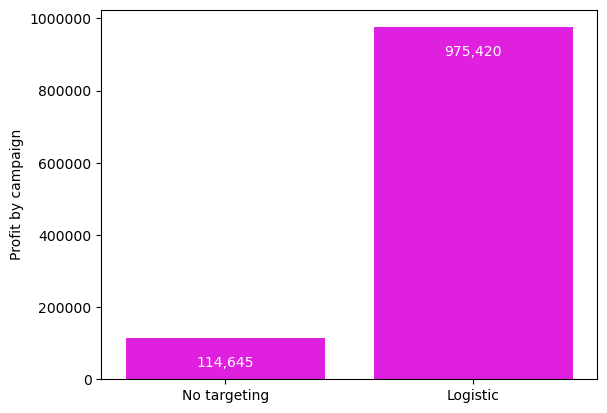

In [41]:
from matplotlib.ticker import FuncFormatter
# Function to format y-axis labels
def millions_formatter(x, pos):
    return f'{int(x)}'
plt.clf()
fig = sns.barplot(data= performance_data1,x='campaign', y='Profit', color='magenta')
fig.set(xlabel="", ylabel='Profit by campaign')
fig.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
for index, row in performance_data1.iterrows():
    fig.text(
        row.name, row.Profit -80000, f"{int(row.Profit):,}", color="white", ha="center"
    )
plt.show()

Create a bar chart with ROME for the analyses conducted above

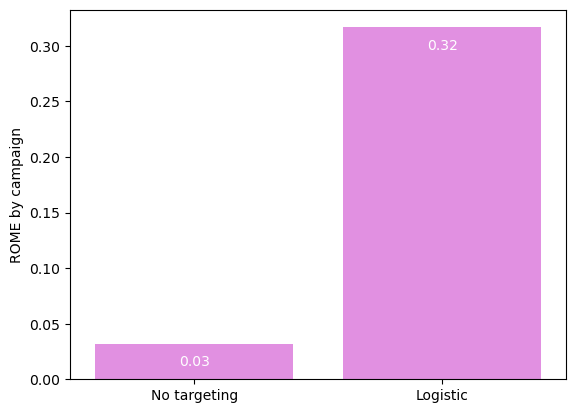

In [40]:
plt.clf()
fig = sns.barplot(data= performance_data1,x='campaign', y='ROME', color='violet')
fig.set(xlabel="", ylabel='ROME by campaign')
for index, row in performance_data1.iterrows():
    fig.text(
        row.name, row.ROME -0.02, f"{row.ROME:.2f}", color="white", ha="center"
    )
plt.show()